# To Hold or to Sell: Mastering Sequential Decision Analytics in Financial Markets with Simple Policy Rules

## Intro 
In this toturial, we are working on illustration of the concept of sequential decision making. Sequential decision making is type of decision making where we have alternate of:

*Decision, uncertainty, decision, uncertainty, ... , decision, uncertainty, decision*

While this type of decision making is common in finance and in real life, how to frame and implement it in practice using python has not been developed yet.

Essentially, in this type of problem, the goal is to find the optimal decision policy that, so it maximizes the expected outcome for decision maker.

Though often, finding the *optimal* policy is not feasible. Some methods or techniques like Dynamic Programming can be used to find the optimal policy. But, these methods are computationally intensive and may not be practical for large or complex problems. Reinforcement Learning is another type of method that can be used to find the optimal policy.

Here, we use *Heuristic* methods to find the *good-enough* policy. It  is simple, can be improved and most importantly, the decision making policy is easy to explain to stakeholders.

Essentially, in this method, we come up with a simple policy rule based on our knowledge of the problem and then use simulation to see how well it performs. Though this simple policy rule has *tunable* parameters, where through simulations we can find the "best" parameters. In other words, we are relying on simulation-evaluation method, to find the *decision-policy* that is good-enough for practical uses.

## English Narrative of the Problem

This is the English narrative of the problem:

You are holding a block of shares of stock, looking for an opportune time to sell. Assume that you are a small player in the market, which means it doesn't matter how many shares you sell, so you'll assume you have just one share. 

Now, for some time horizon,  lets say 30 days, you need to decide when to sell the stock. Starting from day 0, you have 30 decision nodes that you can sell the stock. Then the question is, what decision policy should you use to maximize your profit?'

Assume you have 100 shares of stock NVIDIA (NVDA) and you bought them at $100 per share. Now, have to decide in next 30 days when to sell the stock.Though, the NVIDIA stock is uncertain.

Using heuristic policy, we can come up with a simpl rule for when to sell the stock. This rule is based on the the current price of the stock, in simple cases, and also the heuristic policy has tunable parameters.

Through simulation of the uncertain price process, we can evaluate the performance of the heuristic policy for $N=1000$ sample paths, and then see on avergae how much profit we can make, given that policy.




##  The Basic Model


Let's start by defining the basic model components as described in the text:

### 1.1 State Variables

Our process has two state variables:
- The "physical state" $R_t$, which captures whether or not we are still holding the asset
- The "informational state" $p_t$, which is the price of the stock

The physical state is defined as:

$$R_t = \begin{cases}
1 & \text{If we are holding the stock at time } t,\\
0 & \text{If we are no longer holding the stock at time } t.
\end{cases}$$

Our state variable is then $S_t = (R_t, p_t)$. 

So now, our decision policy need to map this state to a decision. Think about state as *situation* and decision as *action*. You want to find the best policy that maps the situation to the best action.

### 1.2 Decision Variables

The decision variable is whether to hold or sell the stock. We write this using:

$$x_t = \begin{cases}
1 & \text{If we sell the stock at time } t,\\
0 & \text{If we do not sell the stock at time } t.
\end{cases}$$

We can only sell the stock if we are holding it, so we have the constraint $x_t \leq R_t$.

### 1.3 Exogenous Information

The only random process in our basic model is the change in price $\hat{p}_{t+1} = p_{t+1} - p_t$. The price evolves according to:

$$p_{t+1} = p_t + \hat{p}_{t+1}$$

Here we are quite flexible to define the price process. The $\hat{p}_{t+1}$ can come from any distribution. In this example, we will use normal distribution with mean 0.1 and standard deviation 1.

### 1.4 Transition Function

The transition function describes how the state evolves. For $R_t$, we have:

$$R_{t+1} = R_t - x_t$$

This is quite simple. If you sell the stock, you no longer hold it.

For $p_t$, we have:

$$p_{t+1} = p_t + \hat{p}_{t+1}$$

Here it means that the price at time $t+1$ is the price at time $t$ plus the price change at time $t+1$.

### 1.5 Objective Function

Our objective is to maximize the price at which we sell the stock. The contribution function is:

$$C(S_t, x_t) = p_t x_t$$

Since $x_t = 0$ until we sell our asset, at which point $x_t = 1$, this will happen just once over our horizon.

The way we can define the reward for one sample path is as follows:

$$F^\pi(\omega) = \sum_{t=0}^T p_t(\omega)X^\pi(S_t(\omega)) | S_0$$

Here, what we are doing is that from time 0 to time $T$, we are finding time that the decision is to sell the stock, where the $X^\pi$ is 1, multiplying the price at that time by 1. For all other time, the decsion is to hold the stock, where the $X^\pi$ is 0, so the reward is 0. Also, it is important that the policy $\pi$ is based on the initial state $S_0$, which is the initial price of the stock.
 
Though this is result for one sample path. We can define the average reward over all the sample paths as:

$$\overline{F}^\pi = \frac{1}{|\Omega|}\sum_{\omega \in \Omega} F^\pi(\omega)$$

Here, $\Omega$ is the set of all the sample paths. and $|\Omega|$ is the number of sample paths, in code simply it is $N$. We are searching for the policy $\pi$ that maximizes this average reward, $\overline{F}^\pi$.




## Implementing the Python Code


### Modeling Uncertainty

Here, for modeling uncertainity, we assume that the price for next time step is equal to the price at current time step plus a random variable. That random variable is normally distributed with mean  and standard deviation. We call them drift and volatility.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
# Set default grid for all future plots
plt.rcParams['axes.grid'] = True


In [2]:
def generate_price_path(time_horizon, initial_price, drift, volatility):
    """
    Generates a single sample path of stock prices following a random walk.
    
    Parameters:
    -----------
    time_horizon : int
        Number of time periods to simulate (T)
    initial_price : float
        Starting price of the asset (p0)
    drift : float
        Mean of the price change distribution (μ)
    volatility : float
        Standard deviation of the price change distribution (σ)
        
    Returns:
    --------
    prices : numpy.ndarray
        Array of length time_horizon + 1 containing the price at each time step,
        where prices[0] is the initial price and prices[t] is the price at time t.
    """
    # Initialize price array with the initial price
    prices = np.zeros(time_horizon + 1)
    prices[0] = initial_price
    
    # Generate all price changes at once (vectorized approach)
    for t in range(time_horizon):
        prices[t+1] = prices[t] + np.random.normal(loc=drift, scale=volatility)
    
    return prices

As a example, here is the price path for 30 days with drift 0.1 and volatility 1.0. The initial price is 50.0. and we set the seed to 42 for reproducibility.



Text(0.5, 0, 'Time')

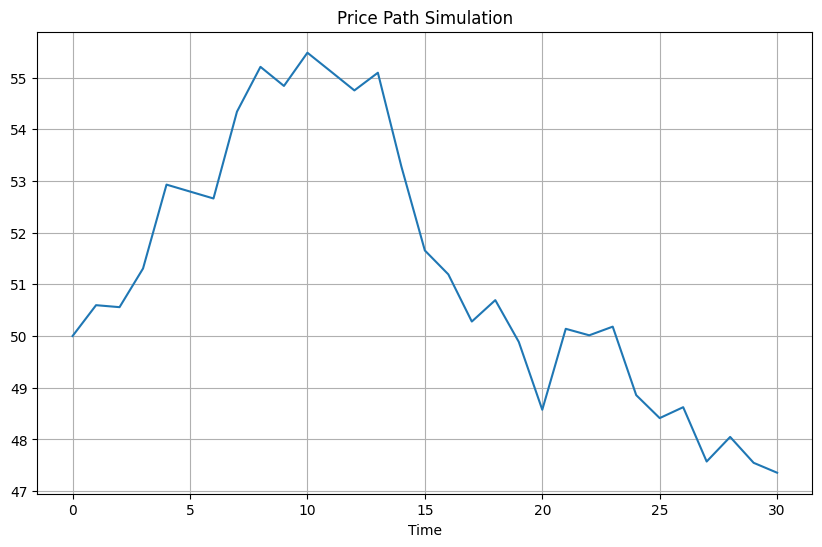

In [6]:
np.random.seed(42)

# Simulation Parameters
T = 30       # Time horizon (number of periods to potentially hold)
p0 = 50.0    # Initial stock price
mu = 0.1     # Mean of price *change* (as per text example)
sigma = 1.0  # Standard deviation of price *change*

test_prices = generate_price_path(time_horizon = T, 
                                  initial_price = p0, 
                                  drift = mu, 
                                  volatility = sigma)

# Plot the price path
plt.figure(figsize=(10, 6))
plt.plot(test_prices, label='Price Path')
plt.title('Price Path Simulation')
plt.xlabel('Time (Days)')

## Designing Policies

As we discussed in the text, we start with simple policy, which is the high-low policy. This policy sells if the price is either too high or too low. Essentially, it is a simple heuristic policy.


###  High-Low Policy



$$X^{high-low}(S_t|\theta_{high-low}) = \begin{cases}
1 & \text{If } p_t < \theta_{low} \text{ or } p_t > \theta_{high}\\
1 & \text{If } t = T \text{ and } R_t = 1\\
0 & \text{Otherwise}
\end{cases}$$

Let's implement this policy and test it:


In [10]:
def policy_high_low(state, t, T, params):
    """
    Implements the high-low policy (Eq 2.14).
    Args:
        state (tuple): Current state (R_t, p_t) where R_t is 1 if holding, 0 otherwise.
        t (int): Current time step (decision period index 0 to T-1).
        T (int): Horizon length (total number of potential holding periods).
        params (dict): Dictionary containing policy parameters, e.g., {'theta_low': 45.0, 'theta_high': 55.0}.

    Returns:
        int: Decision x_t (1 to sell, 0 to hold).
    """
    R_t, p_t = state
    theta_low = params['theta_low']
    theta_high = params['theta_high']

    # Cannot sell if not holding
    if R_t == 0:
        return 0

    # Decision logic from Eq 2.14 (simplified - forced sale at T handled by simulation loop)
    # Sell if price is below lower threshold OR above upper threshold
    if p_t < theta_low or p_t > theta_high:
       decision = 1
    else:
       decision = 0

    # Ensure we only try to sell if holding (redundant given R_t check above, but safe)
    return decision * R_t

Essentially, the policy does that it look at state and if the price is below lower threshold or above upper threshold, it sells the stock. The decision is 1 if we sell the stock and 0 if we hold the stock.

Now write function to test this policy for one sample path:

In [12]:
def simulate_one_path(policy_func, policy_params, T, p0, mu, sigma):
    """
    Simulates one sample path (omega) using a given policy.
    Calculates F_hat_pi(omega).

    Args:
        policy_func (function): The policy function to use (e.g., policy_sell_low).
        policy_params (dict): Parameters for the policy function.
        T (int): Horizon length (decisions from t=0 to T-1).
        p0 (float): Initial price.
        mu (float): Mean price change.
        sigma (float): Std dev price change.

    Returns:
        float: The final selling price obtained on this path (F_hat_pi(omega)).
               Returns 0 if somehow not sold (shouldn't happen with forced sale).
    """
    # Generate the full potential price path for this simulation run (omega)
    # prices array has length T+1 (indices 0 to T)
    prices = generate_price_path(T, p0, mu, sigma)
    #print(prices)
    # Initialize state S_0
    R_t = 1  # Start holding the asset (physical state)
    p_t = prices[0] # Initial price (information state)
    state = (R_t, p_t)

    selling_price = 0.0
    sell_time = -1

    # Simulate decision steps t = 0, 1, ..., T-1
    for t in range(T):
        p_t = prices[t]       # Price at the beginning of period t (relevant for decision x_t)
        state = (R_t, p_t)

        # Check if already sold in a previous period
        if R_t == 0:
            continue # Process stopped for this path, price already recorded

        # Get decision x_t from the policy based on state at time t
        # Note: T in policy function is horizon length, t is current step
        x_t = policy_func(state, t, T, policy_params)

        # Implement transition based on decision x_t
        if x_t == 1:
            # Sell action taken at time t based on price p_t
            selling_price = p_t  # Contribution C(S_t, x_t) = p_t * 1
            R_t = 0 # Update physical state R_{t+1} = R_t - x_t = 1 - 1 = 0
            sell_time = t
            # No need to continue simulation once sold
            break
        else:
            # Hold action taken (x_t = 0)
            R_t = R_t # R_{t+1} = R_t - 0 = R_t (remains 1)
            # Price transitions automatically via the pre-generated 'prices' array for p_{t+1}
            pass

    # Handle forced sale at the end (if not sold earlier)
    # If the loop finishes (meaning we held at T-1), we are forced to sell.
    # The relevant price is the final price p_T (index T in the array).
    if R_t == 1:
       selling_price = prices[T] # Sell at the final available price
       sell_time = T

    # This is F_hat_pi(omega) for this specific path
    return selling_price, sell_time

Now let's test this policy for one sample path:

In [25]:
# Set a seed for reproducibility
np.random.seed(42)

# Define parameters
T = 30           # Time horizon
p0 = 50.0        # Initial price
mu = 0.1       # Mean price change
sigma = 2.0      # Standard deviation of price change

# Define high-low policy parameters
policy_params = {'theta_low': 45.0, 'theta_high': 55.0}

# Run the simulation
selling_price, sell_time = simulate_one_path(
    policy_func=policy_high_low, 
    policy_params=policy_params, 
    T=T, p0=p0, 
    mu=mu, 
    sigma=sigma
)

# Print the result
print(f"Using high-low policy with θ_low={policy_params['theta_low']} and θ_high={policy_params['theta_high']}")
print(f"Selling price: {selling_price:.2f}")
print(f"Sell time: {sell_time}")


Using high-low policy with θ_low=45.0 and θ_high=55.0
Selling price: 55.46
Sell time: 4


The result is that the policy sells the stock at time 8 when the price is 55.21.

## Policy Evaluation

In the previous section, we evaluated the policy for one sample path. Now, we will evaluate the policy for multiple sample paths and compute the average selling price and the standard deviation of the selling price. 
Here teh goal is to get performance of the policy over multiple sample paths, which essentially is teh underlying uncertainty in the price process.

In [30]:
def evaluate_policy(policy_func, policy_params, N, T, p0, mu, sigma):
    """
    Evaluates a policy by simulating N sample paths and averaging results.
    Calculates F_pi (average performance) and its standard error.

    Args:
        policy_func (function): The policy function.
        policy_params (dict): Parameters for the policy function.
        N (int): Number of sample paths (simulations) to run.
        T, p0, mu, sigma: Simulation parameters.

    Returns:
        tuple: (average_selling_price, std_dev_selling_price, std_error_mean)
               average_selling_price is F_pi estimate.
    """
    results = []
    for _ in range(N):
        selling_price,_ = simulate_one_path(policy_func, policy_params, T, p0, mu, sigma)
        results.append(selling_price)

    results = np.array(results)
    average_selling_price = np.mean(results) # F_pi estimate (Eq 2.9)
    # Use ddof=1 for sample standard deviation (unbiased estimate of population variance)
    std_dev_selling_price = np.std(results, ddof=1) # Sample std dev (sqrt of variance in text)
    std_error_mean = std_dev_selling_price / np.sqrt(N) # Std dev of the *average* F_pi (sqrt of (sigma_bar_pi)^2)

    return average_selling_price, std_dev_selling_price, std_error_mean

We can now evaluate the policy for multiple sample paths, here we set N=1000 and T=30.


In [35]:
# Evaluate high-low policy
policy_params = {'theta_low': 45.0, 'theta_high': 55.0}

sigma = 2.0
mu = 0.1
p0 = 50.0
T = 30
N = 1000

# Get all three metrics from policy evaluation
avg_price, std_dev, std_error = evaluate_policy(policy_func=policy_high_low, 
                                              policy_params=policy_params, 
                                              N=N, T=T, p0=p0, mu=mu, 
                                              sigma=sigma)

# Print each metric separately for better understanding
print(f"Average Selling Price: {avg_price:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Standard Error: {std_error:.4f}")

Average Selling Price: 51.1473
Standard Deviation: 6.1106
Standard Error: 0.1932


The result is that average profit we can make from imeplemneting this policy is 50.21. The standard deviation is 1.99 and the standard error is 0.06. These are performance metrics for this policy.

## Search for the best policy

We have seen that teh initial policy has two tunable parameters, which are the lower and upper thresholds. Now, we will search for the best policy by trying different values for these parameters. Here, we are searching for the best policy by trying different values for these parameters.

We will try three different policies:
1. **Balanced Band (θ_low=48, θ_high=52)**: A symmetric policy that provides balanced protection and profit potential around p0=50.
2. **Wider Band (θ_low=45, θ_high=55)**: A wider band with a higher target, designed to capture upward drift.
3. **Aggressive Take-Profit (θ_low=30, θ_high=70)**: Focuses solely on the upper threshold, effectively ignoring downside protection. 

We'll evaluate these policies and visualize their performance.

In [38]:
def run_policy_comparison(N=100000, T=30, p0=50.0, mu=0.1, sigma=2.0):
    """
    Runs a comparison of the three policies and returns their performance metrics.
    
    Args:
        N: Number of simulation paths
        T: Time horizon
        p0: Initial price
        mu: Mean price change (drift)
        sigma: Volatility of price change
        
    Returns:
        Dictionary containing the performance metrics for each policy
    """
    # Define the three policies
    balanced_band_params = {'theta_low': 48.0, 'theta_high': 52.0}
    ride_the_trend_params = {'theta_low': 45.0, 'theta_high': 55.0}
    aggressive_take_profit_params = {'theta_low': 30.0, 'theta_high': 70.0}
    
    # Set a seed for reproducibility
    #np.random.seed(42)
    
    # Evaluate each policy
    print("Evaluating Balanced Band policy...")
    balanced_result = evaluate_policy(
        policy_func=policy_high_low,
        policy_params=balanced_band_params,
        N=N, T=T, p0=p0, mu=mu, sigma=sigma
    )
    
    print("Evaluating Wider Band policy...")
    ride_trend_result = evaluate_policy(
        policy_func=policy_high_low, 
        policy_params=ride_the_trend_params,
        N=N, T=T, p0=p0, mu=mu, sigma=sigma
    )
    
    print("Evaluating Aggressive Take-Profit policy...")
    aggressive_result = evaluate_policy(
        policy_func=policy_high_low,
        policy_params=aggressive_take_profit_params,
        N=N, T=T, p0=p0, mu=mu, sigma=sigma
    )
    
    # Organize results
    results = {
        "Balanced Band": {
            "params": balanced_band_params,
            "avg_price": balanced_result[0],
            "std_dev": balanced_result[1],
            "std_error": balanced_result[2]
        },
        "Wider Band": {
            "params": ride_the_trend_params,
            "avg_price": ride_trend_result[0],
            "std_dev": ride_trend_result[1],
            "std_error": ride_trend_result[2]
        },
        "Aggressive Take-Profit": {
            "params": aggressive_take_profit_params,
            "avg_price": aggressive_result[0],
            "std_dev": aggressive_result[1],
            "std_error": aggressive_result[2]
        }
    }
    
    return results

# Run the policy comparison
policy_results = run_policy_comparison(N=100000)

# Display the results in a table
import pandas as pd

results_df = pd.DataFrame({
    'Policy': ['Balanced Band', 'Wider Band', 'Aggressive Take-Profit'],
    'θ_low': [policy_results[p]['params']['theta_low'] for p in policy_results],
    'θ_high': [policy_results[p]['params']['theta_high'] for p in policy_results],
    'Avg. Selling Price': [policy_results[p]['avg_price'] for p in policy_results],
    'Std Dev': [policy_results[p]['std_dev'] for p in policy_results],
    'Std Error': [policy_results[p]['std_error'] for p in policy_results]
})

display(results_df)

Evaluating Balanced Band policy...
Evaluating Wider Band policy...
Evaluating Aggressive Take-Profit policy...


,Policy,θ_low,θ_high,Avg. Selling Price,Std Dev,Std Error
0,Balanced Band,48.0,52.0,50.260880,3.327245,0.010522
1,Wider Band,45.0,55.0,50.944431,6.117307,0.019345
2,Aggressive Take-Profit,30.0,70.0,52.887936,10.723249,0.033910


We can visualize the performance of the three policies in the following plot:

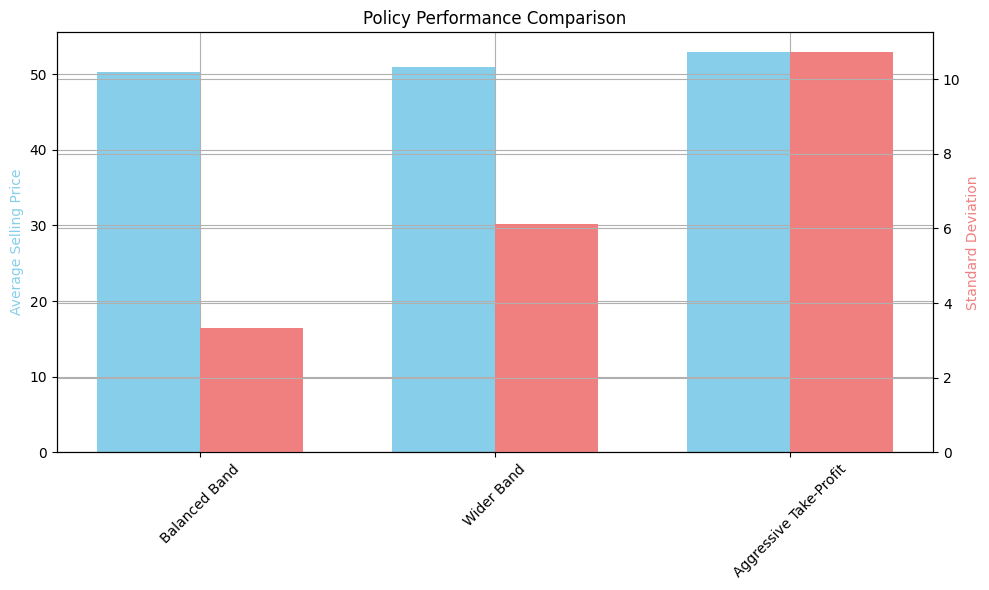

In [40]:
import matplotlib.pyplot as plt

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Set width of bars
width = 0.35

# Create bars
policies = results_df['Policy']
x = range(len(policies))
ax1.bar([i - width/2 for i in x], results_df['Avg. Selling Price'], width, color='skyblue', label='Avg. Selling Price')
ax2.bar([i + width/2 for i in x], results_df['Std Dev'], width, color='lightcoral', label='Std Dev')

# Customize axes
ax1.set_ylabel('Average Selling Price', color='skyblue')
ax2.set_ylabel('Standard Deviation', color='lightcoral')
ax1.set_xticks(x)
ax1.set_xticklabels(policies, rotation=45)

# Add title
plt.title('Policy Performance Comparison')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save high quality plot
plt.savefig('./image/policy_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


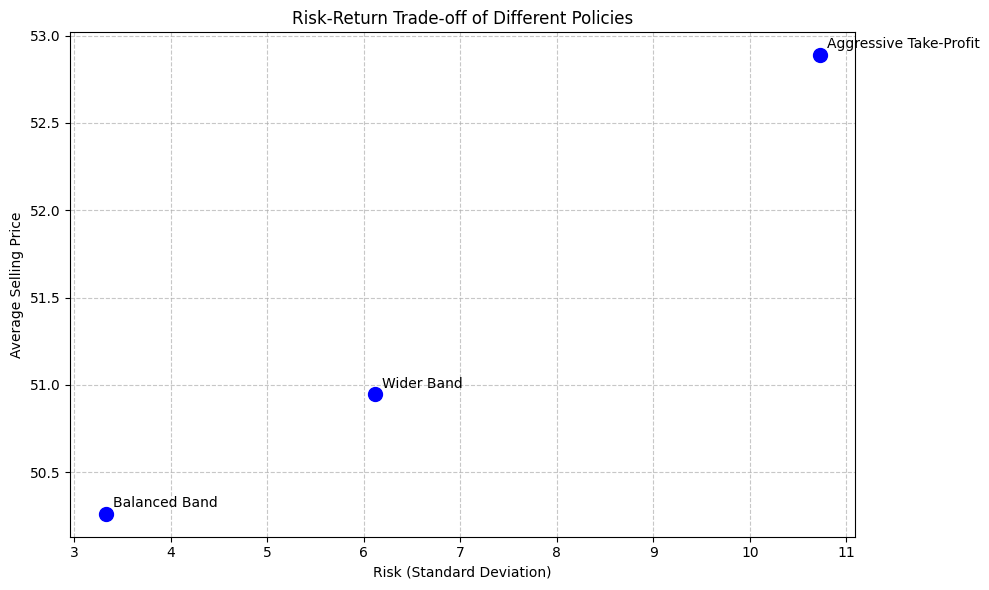

In [41]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(10, 6))

# Create scatter plot
plt.scatter(results_df['Std Dev'], results_df['Avg. Selling Price'], 
           color='blue', s=100)

# Add labels for each point
for i, policy in enumerate(results_df['Policy']):
    plt.annotate(policy, 
                (results_df['Std Dev'][i], results_df['Avg. Selling Price'][i]),
                xytext=(5, 5), textcoords='offset points')

# Customize axes
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Average Selling Price')
plt.title('Risk-Return Trade-off of Different Policies')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save high quality plot
plt.savefig('./image/risk_return_tradeoff.png', dpi=300, bbox_inches='tight')

plt.show()


What we can see from evalauting the three policies is that we do not have a best policy, rather trade-off between the profit and the risk. The Aggressive Take-Profit policy has the highest profit, but also the highest risk, due to its high standard deviation. The Balanced Band policy has the lowest profit, but also the lowest risk, due to its low standard deviation. The Wider Band policy is in the middle of the road, with moderate profit and risk.

Here the risk appetite of the decision maker will determine which policy to implement. If the decision maker is risk averse, they will choose the Balanced Band policy. If the decision maker is risk tolerant, they will choose the Aggressive Take-Profit policy. And if the decision maker is in the middle, they will choose the Wider Band policy.

## Conclusion

In this notebook, we have implemented the asset selling problem as described in the text. We have explored different policies for deciding when to sell an asset, evaluated their performance through simulation, and examined the impact of different price models.

Key takeaways:

- Sequential decision making is a framework that allows us to frame and solve decision problems in a consistent manner. The idea is first to identify and model the essential elements of the problem (states, decisions, uncertainty, objective), then to design and evaluate simple heuristic policies as starting point.

- Then, through the power of simulation, we can evaluate and compare the performance of different policies, and select the best one based on the stakeholder's risk tolerance.

- It seems starting with simple policies is a good idea, as it allows us to quickly iterate and improve the policy, while communicating the results to stakeholders in a way that is easy to understand.